In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Densenet-121-256x256 - Full

This notebook was build to extract features from a DenseNet-121 trained to identify the presence of malign or bening lesions in patches of size 256x256. The patches are subsamples of full size mammographies, as the ones we are using to feed the generative models.

The features are extracted at the end of the feature section of DenseNet, before the linear classifier.

**Some details of DenseNet-121:**
* Four denseblocks with (6, 12, 24, 16)x2 conv layers respectively. The x2 is because it has a Conv1x1 and Conv3x3.
* Three transition layers with one conv layer each.
* One input and one output layer. (still need to check this)
* Final layer count: (6 + 12 + 24 + 16)x2 + 5 = 121

In [3]:
import sys
sys.path.insert(0,'/u/f/fbarone/Documents/breast_cancer_classifier')

import numpy as np
import random
import imageio
import os,sys
import argparse
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import models, transforms
from torchvision import transforms, utils
from torchvision import datasets


from mm_patch.data import PatchesDataset
import mm_patch.transforms
from mm_patch.utils import image_from_index


# NYU breast cancer scripts
import src.heatmaps.models as models
import src.heatmaps.run_producer as run

In [4]:
# Transformations to be compatible with Densenet-121 from NYU paper.
# Note I am using mean and std as recommended in Pytorch. Maybe calculating the dataset statistics is better.
composed = transforms.Compose([ 
#                                 mm_patch.transforms.ToImage(),
                                transforms.ToTensor(),
                                mm_patch.transforms.Scale(),
                                mm_patch.transforms.GrayToRGB(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

In [5]:
def read_image_png(file_name):
    image = np.array(imageio.imread(file_name)).astype(np.int32)
    return image

patches = datasets.ImageFolder('../patches_images/patches_CRO_23072019/', transform=composed, target_transform=None, loader=read_image_png)

In [ ]:
patches[1]

In [6]:
# # Set dataset
# patches = PatchesDataset(data_path='./patches_256x256.pkl', transform = composed)

# Dataloader parameters
batch_size = 10
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(patches)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# this train loader is to have random access
loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                            num_workers=10)
train_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=10)
validation_loader = torch.utils.data.DataLoader(patches, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=10)

## Densenet-121 Model 
We have to load the model parameters from the NYU breast_cancer_classifier github: 
'./models/sample_patch_model.p'

In [ ]:
parameters = {}

parameters['device_type'] = "cpu"
parameters['gpu_number'] = 0
# number of classes of Densenet classifier (it is not the same as dense/venous!)
parameters['number_of_classes'] = 4
parameters['initial_parameters'] = '/u/f/fbarone/Documents/breast_cancer_classifier/models/sample_patch_model.p'

model, device = run.load_model(parameters)

In [ ]:
from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
summary(model, input_size=(3, 256, 256))

In [ ]:
# Easy way of checking layer names (you have to be careful because names are not exactly the same)
# model.state_dict().keys()

In [ ]:
batch = next(iter(loader))
batch[0].shape

## Set up hooks

In [ ]:
# get activations
def get_activation(layer_dict, name):
    """
    Define hook to extract intermediate layer features
    """
    def hook(model, input, output):
        layer_dict[name].append(output.detach())
        # layer_dict[name] = torch.cat(layer_dict[name], output.detach())
    return hook


# get activations densenet
def get_activation_densenet(layer_dict, name, batch_size):
    """
    Define hook to extract intermediate layer features
    """
    def hook(model, input, output):
        output = F.adaptive_avg_pool2d(output.detach(), (1, 1)).view(batch_size, -1)
#         print(output.shape)
        layer_dict[name].append(output)
        # layer_dict[name] = torch.cat(layer_dict[name], output.detach())
    return hook

In [ ]:
# register hook
activations = {'norm5': []}
handle_linear = model.densenet.features.norm5.register_forward_hook(get_activation_densenet(activations, 'norm5', batch_size))

In [ ]:
from tqdm import tqdm as tqdm
with torch.no_grad():
#     output = [(densenet(batch['patch']), batch['target']) for batch in loader]
        output = [F.softmax(model(torch.FloatTensor(batch[0]).to(device)), dim=1).cpu().detach().numpy() 
                  for batch in tqdm(loader)]


In [ ]:
features = torch.cat(activations['norm5'], 0)
features.shape

### Save features

In [ ]:
# # print(features.shape)
# file_path = '/u/f/fbarone/Documents/patches_analysis/73000/densenet_1024_256x256.txt'
# with open(file_path, 'w') as file: 
#     np.savetxt(file, features.numpy())


### Load features

In [ ]:
file_path = '/u/f/fbarone/Documents/patches_analysis/73000/densenet_1024_256x256.txt'
with open(file_path, 'r') as file: 
    features = np.loadtxt(file)


## Intrinsic Dimension

In [ ]:
import sys
sys.path.insert(0,'/u/f/fbarone/Documents/TWO-NN')
import id2nn

### Activation before linear classifier (ED = 1024)

To get the activation before the linear classifier we have to take the output of densenet.feature, activations\['norm5'\], and apply an F.adaptive_avg_pool2d + a flatten operation.

In numbers:

```
activation['norm5'] = (n_batch, 1024, 8, 8)
F.adaptive_avg_pool2d(out_batch, (1, 1)).view(n_batch, -1) = (n_batch, 1024)
```
Thus the input of the classifier is of dimension 1024.



In [ ]:
np.random.seed(10)

blocks_dim, blocks_dim_std, blocks_size, d_mat2 = id2nn.two_nn_block_analysis(features, .9, shuffle = True)

# file_path = './activations_alexnet/block_analysis_linear.txt'
# with open(file_path, 'wb') as file: 
#     np.savetxt(file, np.array(blocks_dim))
#     np.savetxt(file, np.array(blocks_dim_std))


In [ ]:
import matplotlib.pyplot as plt

plt.plot(blocks_size, blocks_dim, "r.-")
plt.errorbar(blocks_size, blocks_dim, fmt = "r.-", yerr = np.array(blocks_dim_std))
plt.xlabel('block size')
plt.ylabel('intrinsic dimension')
plt.title('Before classifier [ED = 1024]')
plt.show()

### ID for input data

In [ ]:
# build data into single numpy array
input_data = []
for row in patches.data['patch']:
    row = np.array(row)
#     print(type(row))
#     print(row)
    input_data.append(row.flatten(-1))
    
input_data = np.asarray(input_data)
input_data.shape


In [ ]:
# calculate id
blocks_dim_input, blocks_dim_std_input, blocks_size_input, _ = id2nn.two_nn_block_analysis(input_data, .9, shuffle = True)

In [ ]:
plt.errorbar(blocks_size_input, blocks_dim_input, fmt = "r.-", yerr = np.array(blocks_dim_std_input))
plt.xlabel('block size')
plt.ylabel('intrinsic dimension')
plt.title('Input data [ED = 256*256]')
plt.show()

## PCA

In [ ]:
from numpy import linalg as LA
from numpy import cov
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
x = features

print(f'features shape before{x.shape}')
# define scaler instance
# scaler = preprocessing.StandardScaler()

print(features.shape)
# features_ts = scaler.fit_transform(features)
x_centered = x - np.mean(x, axis=0)


# Own implementation (stability error)
# cov_mat = cov(x_centered.T)
# print(cov_mat.shape)

# # Calculate Eigenvectors and Eigenvalues
# w, v = LA.eig(cov_mat)
# print("w:", w)
# # print("v:", v)


# Using scipy package


# percentage of variance explained
# can also use: PCA(n_components=2)
pca = PCA(n_components=0.95)
x_centered = pca.fit_transform(x_centered)
# pca.explained_variance_ are the eigenvalues
eigenvalues = pca.explained_variance_ 
print(len(eigenvalues))
# pca.components_ are the eigenvectors
# print(pca.components_[1,:])

print(f'features shape after{x_centered.shape}')

# Plot eigenvalues 
plt.plot(np.log(eigenvalues), '.')
plt.ylabel('Eigenvalue $(\lambda)$')
plt.xlabel('$\lambda$ number')
plt.show()

### Save PCA

In [ ]:
# print(features.shape)
# file_path = '/u/f/fbarone/Documents/patches_analysis/73000/features_pca_0.95_256x256.txt'
# with open(file_path, 'w') as file: 
#     np.savetxt(file, x_centered)

# features = 0
# x = 0


### Load PCA

In [ ]:
file_path = '/u/f/fbarone/Documents/patches_analysis/73000/features_pca_0.95_256x256.txt'
with open(file_path, 'r') as file: 
    x_centered = np.loadtxt(file)

In [ ]:
fig = plt.figure(figsize = (20,20))
plt.plot(x_centered[:,0],x_centered[:,1], '.')
x_centered.shape

## TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

### Random sampling of data points.
It is needed because TSNE is too slow to work with 70000 data points.

In [ ]:
# reduce the data points 
np.random.seed(10)
rand_idxs = np.random.choice(len(x_centered), 2800, replace = False)
x_centered_sample = x_centered[rand_idxs]
x_centered_sample.shape

In [ ]:
# TSNE transformation
x_embedded = TSNE(n_components=2, perplexity = 100).fit_transform(x_centered_sample)
x_embedded.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x_embedded[:,0],x_embedded[:,1])

## K-Means

In [7]:
file_path = '/u/f/fbarone/Documents/patches_analysis/73000/features_pca_0.95_256x256.txt'
with open(file_path, 'r') as file: 
    X = np.loadtxt(file)


In [8]:
from sklearn.cluster import KMeans

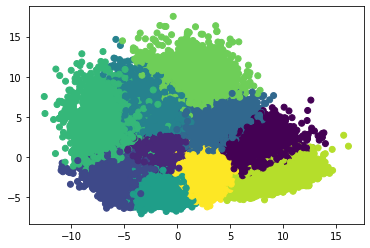

In [9]:
kmeans = KMeans(n_clusters=10).fit(X)
plt.scatter(X[:,0], X[:,1], c = kmeans.labels_)

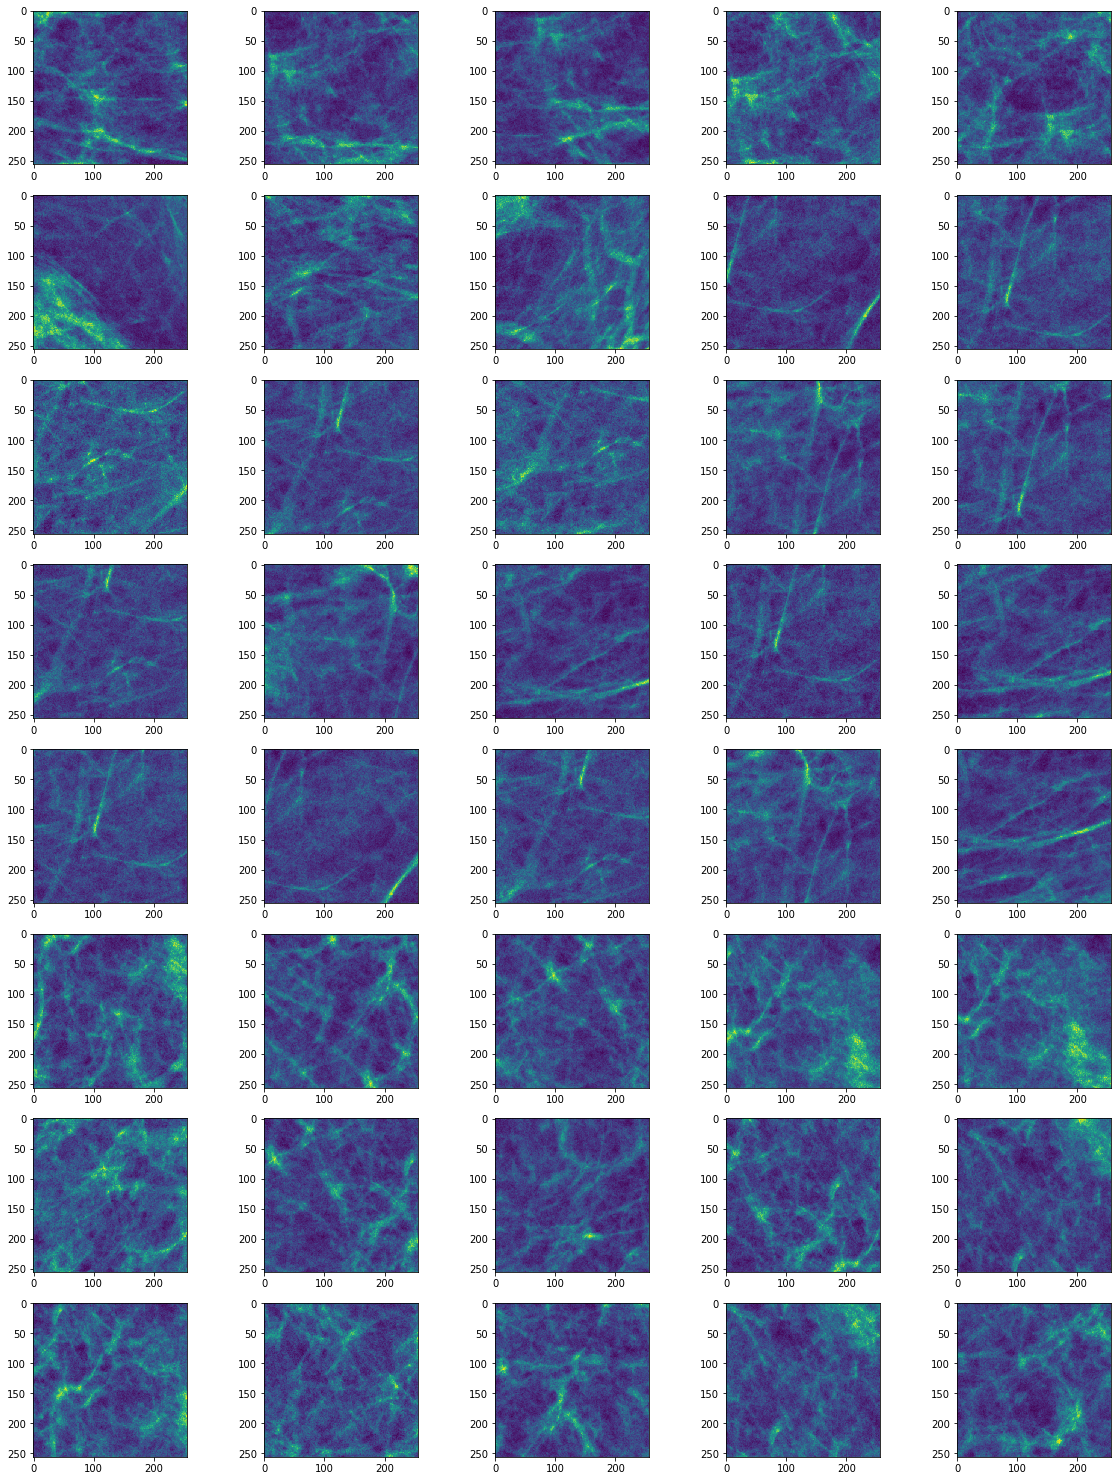

In [32]:
num_patches = 40
cluster = 0

data_len = len(X)
kmeans.labels_ == cluster
index_ls = np.arange(data_len)[kmeans.labels_ == cluster][:num_patches]
images = image_from_index(loader,index_ls)
fig = plt.figure(figsize = (20,30))
cols = 5
rows = num_patches//cols + 1
for i,patch in enumerate(images):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(patch)
plt.show()

### NN per cluster

In [ ]:
images = image_from_index(loader,[1,7,3,12,27,25])
image_from_index?

In [ ]:
# Manual check of image_from_index

# iterator = iter(loader)
# first_batch, _  = next(iterator)
# second_batch, _  = next(iterator)
# third_batch, _  = next(iterator)
# plt.imshow(images[4])
# plt.show()
# # plt.imshow(first_batch[1][0,:,:])
# # plt.imshow(first_batch[7][0,:,:])
# # plt.imshow(first_batch[3][0,:,:])
# # plt.imshow(second_batch[2][0,:,:])
# plt.imshow(third_batch[7][0,:,:])
# plt.imshow(third_batch[5][0,:,:])
# plt.show()

### NN (didn't run it for all dataset yet, maybe is too slow)

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# # X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# # X = x_centered
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# distances, indices = nbrs.kneighbors(X)
# indices                                           

# nn = np.concatenate(indices)